<a href="https://colab.research.google.com/github/BlackDeath1107/TutadorApp/blob/main/Tutador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Original_data_with_more_rows.csv')
df.head()

,Unnamed: 0,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,MathScore,ReadingScore,WritingScore
0,0,female,group B,bachelor's degree,standard,none,72,72,74
1,1,female,group C,some college,standard,completed,69,90,88
2,2,female,group B,master's degree,standard,none,90,95,93
3,3,male,group A,associate's degree,free/reduced,none,47,57,44
4,4,male,group C,some college,standard,none,76,78,75


In [ ]:
df.shape

(30641, 9)

In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
Gender,0
EthnicGroup,0
ParentEduc,0
LunchType,0
TestPrep,0
MathScore,0
ReadingScore,0
WritingScore,0


In [ ]:
scores = df.columns[df.columns.str.contains('score')].tolist()
scores

[]

In [ ]:
for score in scores:
    sns.histplot(df[score], element='bars', kde=True)
    plt.text(x=20, y=90, s=f"Skew: {round(df[score].skew(),2)}\nKurtosis: {round(df[score].kurt(),2)}")
    plt.show()

In [ ]:
df.describe()


,Unnamed: 0,MathScore,ReadingScore,WritingScore
count,30641.000000,30641.000000,30641.000000,30641.000000
mean,499.556607,66.749355,69.624980,68.468327
std,288.747894,15.206049,14.671572,15.307814
min,0.000000,0.000000,10.000000,5.000000
25%,249.000000,56.000000,60.000000,58.000000
50%,500.000000,67.000000,70.000000,69.000000
75%,750.000000,78.000000,80.000000,79.000000
max,999.000000,100.000000,100.000000,100.000000


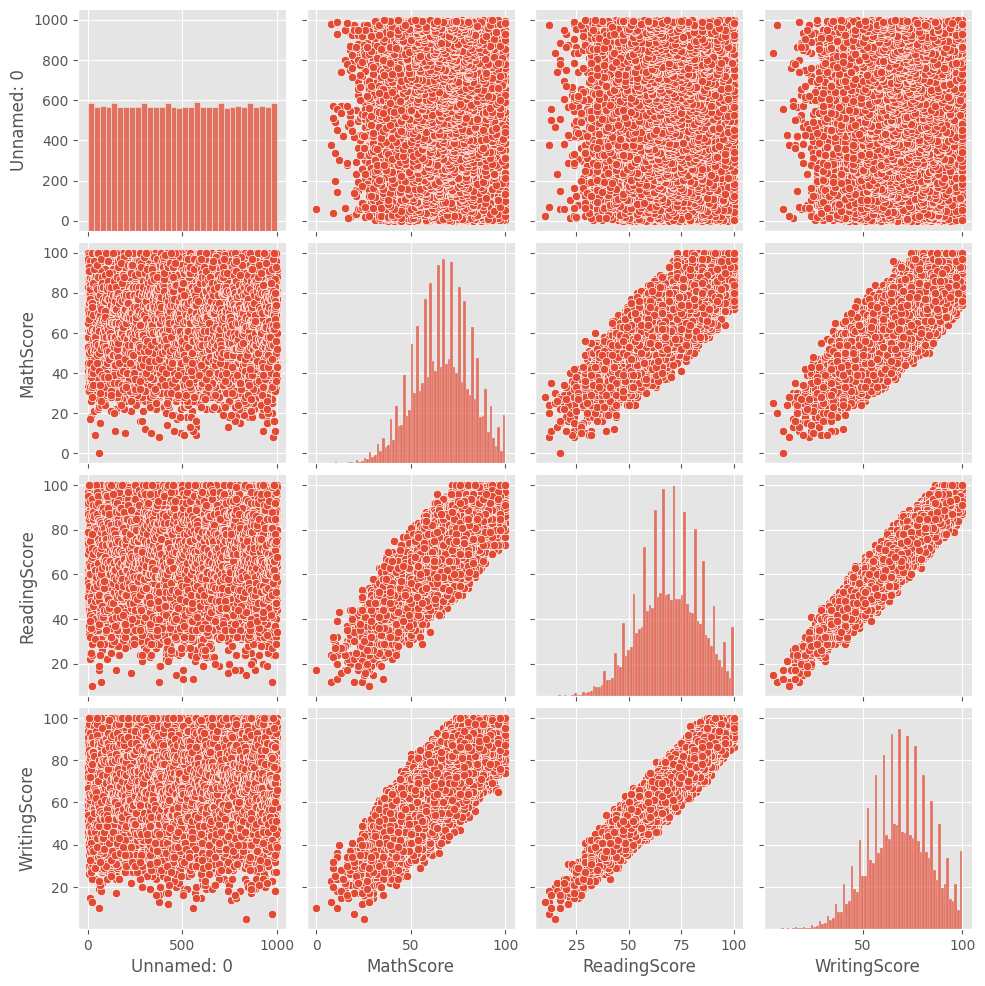

In [ ]:
sns.pairplot(data=df)

In [ ]:
for score in scores:
    sns.boxplot(y=df[score], x=df['test preparation course'])
    plt.show()

In [ ]:
for score in scores:
    plt.figure(figsize=(10,5))
    sns.boxplot(y=df[score], x=df['parental level of education'])
    plt.xticks(rotation=15)
    plt.show()

In [ ]:
X, y = df.drop('WritingScore', axis=1), df['WritingScore']

In [ ]:
cat_cols = X.dtypes[X.dtypes == 'O'].index.tolist()
cat_cols

['Gender', 'EthnicGroup', 'ParentEduc', 'LunchType', 'TestPrep']

In [ ]:
ct = ColumnTransformer([
#     ('num', StandardScaler(), ['ReadingScore', 'MathScore']),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

In [ ]:
ct.fit_transform(X).shape

(30641, 20)

In [ ]:
pipe = Pipeline([
    ('trf', ct),
    ('model', LGBMRegressor(random_state=0))
])

In [ ]:
params = {
    'model__n_estimators':[100,130,150,170,190],
    'model__boosting_type': ['dart', 'gbdt', 'goss']
}

In [ ]:
gs = GridSearchCV(pipe, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1)

In [ ]:
gs.fit(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 465
[LightGBM] [Info] Number of data points in the train set: 30641, number of used features: 20
[LightGBM] [Info] Start training from score 68.468327


GridSearchCV(estimator=Pipeline(steps=[('trf',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Gender',
                                                                          'EthnicGroup',
                                                                          'ParentEduc',
                                                                          'LunchType',
                                                                          'TestPrep'])])),
                                       ('model',
                                        LGBMRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__boosting_type': ['dart', 'gbdt', 'goss'],
                         'model__n_estimators': [100, 130, 150, 170, 190]},
             scoring='neg_root_mean_squared_error')

In [ ]:
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__boosting_type,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.536944,0.123761,0.075788,0.004606,gbdt,100,"{'model__boosting_type': 'gbdt', 'model__n_est...",-3.638874,-3.621505,-3.610248,-3.602254,-3.624606,-3.619497,0.012558,1
6,0.526605,0.029886,0.102814,0.023697,gbdt,130,"{'model__boosting_type': 'gbdt', 'model__n_est...",-3.639282,-3.623430,-3.609011,-3.604621,-3.626869,-3.620643,0.012537,2
7,0.595051,0.052651,0.105399,0.010986,gbdt,150,"{'model__boosting_type': 'gbdt', 'model__n_est...",-3.641649,-3.624423,-3.609690,-3.607288,-3.628092,-3.622228,0.012624,3
8,0.845039,0.210409,0.133626,0.034911,gbdt,170,"{'model__boosting_type': 'gbdt', 'model__n_est...",-3.645148,-3.625527,-3.612184,-3.608692,-3.631972,-3.624705,0.013301,4
9,1.148880,0.073569,0.171175,0.041688,gbdt,190,"{'model__boosting_type': 'gbdt', 'model__n_est...",-3.647602,-3.628363,-3.616208,-3.612137,-3.635316,-3.627925,0.012873,5
10,0.705441,0.021889,0.080714,0.002403,goss,100,"{'model__boosting_type': 'goss', 'model__n_est...",-3.657178,-3.631892,-3.622059,-3.617506,-3.639501,-3.633627,0.014042,6
11,0.842583,0.011360,0.097904,0.007729,goss,130,"{'model__boosting_type': 'goss', 'model__n_est...",-3.660684,-3.632275,-3.633351,-3.622025,-3.642479,-3.638163,0.012993,7
12,0.959330,0.033772,0.114773,0.008366,goss,150,"{'model__boosting_type': 'goss', 'model__n_est...",-3.663237,-3.637376,-3.637553,-3.633980,-3.652192,-3.644867,0.011129,8
13,1.092922,0.057207,0.131511,0.023492,goss,170,"{'model__boosting_type': 'goss', 'model__n_est...",-3.671358,-3.644550,-3.644804,-3.637978,-3.661037,-3.651946,0.012331,9
14,1.800895,0.296655,0.179777,0.053165,goss,190,"{'model__boosting_type': 'goss', 'model__n_est...",-3.677932,-3.646542,-3.655006,-3.643811,-3.672132,-3.659084,0.013658,10


In [ ]:
gs.best_params_

{'model__boosting_type': 'gbdt', 'model__n_estimators': 100}

In [ ]:
gs.best_score_

np.float64(-3.6194973607124252)

In [ ]:
gs.best_estimator_

Pipeline(steps=[('trf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'EthnicGroup',
                                                   'ParentEduc', 'LunchType',
                                                   'TestPrep'])])),
                ('model', LGBMRegressor(random_state=0))])

In [ ]:
joblib.dump(gs.best_estimator_, 'model.joblib')

['model.joblib']

In [ ]:
mdl = joblib.load('model.joblib')

In [ ]:
q = pd.DataFrame([['female', 'group A', 'high school', 'standard', 'completed', 50, 87]],
                 columns=['gender', 'race/ethnicity', 'parental level of education', 'lunch',
                          'test preparation course', 'ReadingScore', 'MathScore'])
q


,gender,race/ethnicity,parental level of education,lunch,test preparation course,ReadingScore,MathScore
0,female,group A,high school,standard,completed,50,87


In [ ]:
# Rename columns in 'q' to match the original training data column names
q = pd.DataFrame([['female', 'group A', 'high school', 'standard', 'completed', 50, 87]],
                 columns=['Gender', 'EthnicGroup', 'ParentEduc', 'LunchType',
                          'TestPrep', 'ReadingScore', 'MathScore'])

# Add the missing 'Unnamed: 0' column and set its value to 0 or any appropriate value
q['Unnamed: 0'] = 0  # Assuming the original index started from 0

# Now you can predict using the renamed columns
mdl.predict(q)

array([61.57794267])